# Funciones Auxiliares

In [112]:
import numpy as np
import sklearn as sk
import pandas as pd
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Generadores

In [113]:
def centroGauss(d, v):
  return [v]*d

def covMatrix(d, C):
  return np.identity(d)*([(C*np.sqrt(d))**2]*d)

def diagonales(n, d, C):
  n0 = int(n/2)
  n1 = n - n0
  matriz = covMatrix(d, C)
  valores0 = np.random.multivariate_normal(centroGauss(d, -1), matriz, n0)
  valores1 = np.random.multivariate_normal(centroGauss(d, 1), matriz, n1)

  data = [[0, *x] for x in valores0] + [[1, *x] for x in valores1]

  return pd.DataFrame(data, columns=['Target', *['d' + str(x + 1) for x in range(d)]])

In [114]:
def covMatrixP(d, C):
  return np.identity(d)*([C**2]*d)

def paralelas(n, d, C):
  n0 = int(n/2)
  n1 = n - n0
  matriz = covMatrixP(d, C)
  centro = centroGauss(d, 0)
  centro[0] = -1
  valores0 = np.random.multivariate_normal(centro, matriz, n0)
  centro[0] = 1
  valores1 = np.random.multivariate_normal(centro, matriz, n1)

  data = [[0, *x] for x in valores0] + [[1, *x] for x in valores1]

  return pd.DataFrame(data, columns=['Target', *['d' + str(x + 1) for x in range(d)]])

In [115]:
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def is_inside_curve(rho, theta, npi):
  rho_curve1 = (theta + (npi-1)*np.pi) / (4 * np.pi)
  rho_curve2 = (theta + npi*np.pi) / (4 * np.pi)
  return rho_curve1 <= rho <= rho_curve2

def is_inside_curves(x, y):
    rho, theta = cartesian_to_polar(x, y)
    return is_inside_curve(rho, theta, 1) or is_inside_curve(rho, theta, 3) or is_inside_curve(rho, theta, 5)

def espirales(n):
  n0 = int(n/2)
  n1 = n - n0
  i0, i1 = 0, 0
  values0, values1 = [], []
  while (i0 + i1 < n):
    x, y = np.random.uniform(-1, 1, 2)
    if (np.sqrt(x**2 + y**2) > 1):
      continue
    if (is_inside_curves(x, y)):
      if (i0 != n0):
        values0.append([x, y])
        i0 += 1
    else:
      if (i1 != n1):
        values1.append([x, y])
        i1 += 1

  data = [[0, *x] for x in values0] + [[1, *x] for x in values1]

  return pd.DataFrame(data, columns=['Target', 'd1', 'd2'])

## Entrenamientos

In [116]:
#función que entrena una red ya definida previamente "evaluaciones" veces, cada vez entrenando un número de épocas elegido al crear la red y midiendo el error en train, validación y test al terminar ese paso de entrenamiento. 
#Guarda y devuelve la red en el paso de evaluación que da el mínimo error de validación
#entradas: la red, las veces que evalua, los datos de entrenamiento y sus respuestas, de validacion y sus respuestas, de test y sus respuestas
#salidas: la red entrenada en el mínimo de validación, los errores de train, validación y test medidos en cada evaluación
def entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test):
  if type(red) == MLPClassifier:
    errorFunc = sk.metrics.zero_one_loss
  else:
    errorFunc = sk.metrics.mean_squared_error

  best_err = 1

  errors_train, errors_val, errors_test = [], [], []
  for n in range(evaluaciones):
    red.fit(X_train, y_train)
    
    pred_train = red.predict(X_train)
    errors_train.append(errorFunc(y_train, pred_train))

    pred_val = red.predict(X_val)
    error_val = errorFunc(y_val, pred_val)
    errors_val.append(error_val)

    pred_test = red.predict(X_test)
    errors_test.append(errorFunc(y_test, pred_test))

    if error_val < best_err:
      best_err = error_val
      best_red = copy.deepcopy(red)

  return best_red, errors_train, errors_val, errors_test

In [117]:
def entrenar_red2(red, evaluaciones, X_train, y_train, X_test, y_test):
  if type(red) == MLPClassifier:
    errorFunc = sk.metrics.zero_one_loss
  else:
    errorFunc = sk.metrics.mean_squared_error

  errors_train, errors_test, weights = [], [], []
  for n in range(evaluaciones):
    red.fit(X_train, y_train)
    
    pred_train = red.predict(X_train)
    errors_train.append(errorFunc(y_train, pred_train))

    pred_test = red.predict(X_test)
    errors_test.append(errorFunc(y_test, pred_test))

    weights.append(np.sum([np.sum(np.square(w)) for w in red.coefs_]))

  return red, errors_train, errors_test, weights

## Plots

In [118]:
def plotGrafico(x, y):
  i, n = 0, len(y)
  xs0, ys0, xs1, ys1 = [], [], [], []
  while (i < n):
    if (y[i] == 0):
      xs0.append(x[i][0])
      ys0.append(x[i][1])
    else:
      xs1.append(x[i][0])
      ys1.append(x[i][1])
    i += 1

  plt.scatter(xs0, ys0, color='red', facecolors='none', label='Clase 0')
  plt.scatter(xs1, ys1, color='green', facecolors='none', label='Clase 1')
  plt.legend()
  plt.show()

In [119]:
def plotEntrenamiento(title, error_train, error_val, error_test, sub_epocas, cant_epocas):
  plt.figure(figsize=(20,12))
  rango = np.array(range(cant_epocas)) * sub_epocas
  plt.plot(rango, error_train, label="Train", linestyle=":")
  plt.plot(rango, error_val, label="Val", linestyle="-.")
  plt.plot(rango, error_test, label="Test", linestyle="-")
  plt.legend()
  plt.title(title)
  plt.show()

In [120]:
def plotEntrenamiento2(title, error_train, error_test, sub_epocas, cant_epocas):
  plt.figure(figsize=(20,12))
  rango = np.array(range(cant_epocas)) * sub_epocas
  plt.plot(rango, error_train, label="Train", linestyle=":")
  plt.plot(rango, error_test, label="Test", linestyle="-")
  plt.legend()
  plt.title(title)
  plt.show()

In [121]:
def plotEntrenamiento3(title, weights, sub_epocas, cant_epocas):
  plt.figure(figsize=(20,12))
  rango = np.array(range(cant_epocas)) * sub_epocas
  plt.plot(rango, weights, label="Test", linestyle="-")
  plt.legend()
  plt.title(title)
  plt.show()

In [122]:
def plotEntrenamiento4(title, arbol_diag, arbol_para, ann_diag, ann_para, dimentions):
  plt.figure(figsize=(20,12))
  
  plt.plot(dimentions, arbol_diag[0], label='Diagonal Tree Train', linestyle="-")
  plt.plot(dimentions, arbol_diag[1], label='Diagonal Tree Test', linestyle="-")
  plt.plot(dimentions, arbol_para[0], label='Paralel Tree Train', linestyle="-")
  plt.plot(dimentions, arbol_para[1], label='Paralel Tree Test', linestyle="-")
  plt.plot(dimentions, ann_diag[0], label='Diagonal ANN Train', linestyle="-")
  plt.plot(dimentions, ann_diag[1], label='Diagonal ANN Test', linestyle="-")
  plt.plot(dimentions, ann_para[0], label='Paralel ANN Train', linestyle="-")
  plt.plot(dimentions, ann_para[1], label='Paralel ANN Test', linestyle="-")
  
  plt.scatter(dimentions, arbol_diag[0], color='blue', s=50)
  plt.scatter(dimentions, arbol_diag[1], color='orange', s=50)
  plt.scatter(dimentions, arbol_para[0], color='green', s=50)
  plt.scatter(dimentions, arbol_para[1], color='red', s=50)
  plt.scatter(dimentions, ann_diag[0], color='purple', s=50)
  plt.scatter(dimentions, ann_diag[1], color='brown', s=50)
  plt.scatter(dimentions, ann_para[0], color='pink', s=50)
  plt.scatter(dimentions, ann_para[1], color='grey', s=50)

  plt.xticks(dimentions, labels=[str(i) for i in dimentions])
  plt.legend()
  plt.title(title)
  plt.show()

In [123]:
def plotEntrenamiento5(title, arbol, ann, dimentions):
  plt.figure(figsize=(20,12))
  
  plt.plot(dimentions, arbol[0], linestyle="-", label='Tree Train')
  plt.plot(dimentions, arbol[1], linestyle="-", label='Tree Test')
  plt.plot(dimentions, ann[0], linestyle="-", label='ANN Train')
  plt.plot(dimentions, ann[1], linestyle="-", label='ANN Test')

  plt.scatter(dimentions, arbol[0], color='blue', s=50)
  plt.scatter(dimentions, arbol[1], color='orange', s=50)
  plt.scatter(dimentions, ann[0], color='green', s=50)
  plt.scatter(dimentions, ann[1], color='red', s=50)

  plt.xticks(dimentions, labels=[str(i) for i in dimentions])
  plt.legend()
  plt.title(title)
  plt.show()

# Ejercicio 1

In [9]:
def clasifEsp(n):
    eta = 0.1
    alfa = 0.9
    sub_epoca = 20
    
    clasif = MLPClassifier(hidden_layer_sizes=(n,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta, momentum=alfa,
                       nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epoca)

    cant_epocas = 1000

    train = espirales(480)
    xTrain = train[['d1', 'd2']].values
    yTrain = train['Target'].values

    val = espirales(120)
    xVal = val[['d1', 'd2']].values
    yVal = val['Target'].values

    test = espirales(2000)
    xTest = test[['d1', 'd2']].values
    yTest = test['Target'].values

    best_red, _, _, _ = entrenar_red(clasif, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)
    
    plotGrafico(xTest, best_red.predict(xTest))
    

## Graficos

### 2 neuronas

c:\Program Files\Microsoft SQL Server\150\PYTHON_SERVER\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


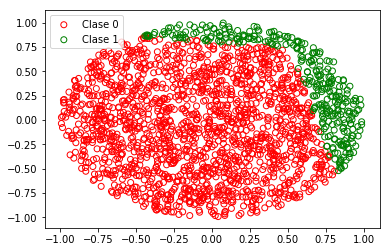

In [13]:
clasifEsp(2)

### 10 neuronas

c:\Program Files\Microsoft SQL Server\150\PYTHON_SERVER\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


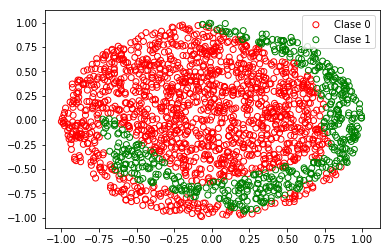

In [17]:
clasifEsp(10)

### 20 neuronas

c:\Program Files\Microsoft SQL Server\150\PYTHON_SERVER\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


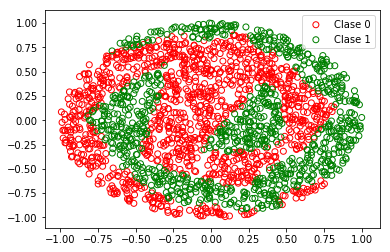

In [42]:
clasifEsp(20)

### 40 neuronas

c:\Program Files\Microsoft SQL Server\150\PYTHON_SERVER\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


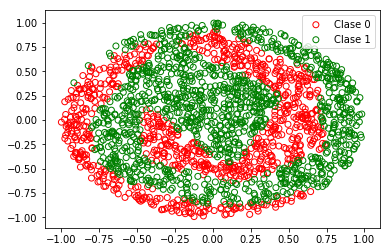

In [62]:
clasifEsp(40)

## Comentarios

Primero que nada, cabe aclarar que para cada número de neuronas, corrí varias veces la función que entrena el modelo, manteniendo las ejecuciones que mejor pudieron predecir el espiral.

Dicho esto, se puede ver una clara mejoría en la predicción de los espirales al aumentar el número de neuronas en la capa intermedia. Esto se debe a que, al ser un problema complejo de predecir, se necesita una gran cantidad de estas para poder acercarnos a un buen resultado. De cualquier manera, pienso que no necesariamente aumentar el número de neuronas en la capa intermedia nos dará mejores resultados. A cierto punto, estas comenzarán a buscar soluciones más complejas al problema que no serán necesarias y probablemente sean perjudiciales para su solución.

También considero que, probablemente, entrenando al clasificador con una mayor cantidad de datos, se podría haber alcanzado un mejor resultado para los casos que usan más neuronas, porque, aun teniendo muchos datos, usando 2 o 4 neuronas, estos clasificadores no podrían conseguir soluciones lo suficientemente complejas como para aproximar los espirales.

# Ejercicio 2

## Calculos

In [167]:
data = pd.read_csv('./dos_elipses.data', header=None, names=['x', 'y', 'Target'])
test = pd.read_csv('./dos_elipses.test', header=None, names=['x', 'y', 'Target'])

dataDF = data.sample(n=500)

xTrain, xVal, yTrain, yVal = train_test_split(dataDF[['x', 'y']].values, dataDF['Target'].values, test_size=0.2)

xTest = test[['x', 'y']].values
yTest = test['Target'].values

In [168]:
momentums = [0, 0.5, 0.9]
learning_rates = [0.1, 0.01, 0.001]
iters = 10
sub_epoca = 50
cant_epocas = 300

In [169]:
def clasifElip():
  values = {}
  best_redes = {}

  for lr in learning_rates:
    for m in momentums:
      errors = []

      for _ in range(iters):
        clasif = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=lr, momentum=m, 
                               nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epoca)
        
        best_red, errors_train, errors_val, errors_test = entrenar_red(clasif, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)

        error_test = sk.metrics.zero_one_loss(yTest, best_red.predict(xTest))

        red = {'best_red': best_red, 'errors_train': errors_train, 'errors_val': errors_val, 'errors_test': errors_test, 'error_test': error_test}

        if (lr, m) not in best_redes:
          best_redes[(lr, m)] = red
        else:
          error_test2 = best_redes[(lr, m)]["error_test"]
          if error_test < error_test2:
            best_redes[(lr, m)] = red

        errors.append(error_test)

      values[(lr, m)] = (sum(errors)/len(errors))

  return (values, best_redes)

## Resultados

In [170]:
values, best_redes = clasifElip()

In [171]:
valoresFinales = []

for lr, m in [(lr, m) for lr in learning_rates for m in momentums]:
  valoresFinales.append((lr, m, values[(lr, m)], best_redes[(lr, m)]["error_test"]))

valoresDF = pd.DataFrame(valoresFinales, columns=['Learning Rate', 'Momentum', 'Error Promedio', 'Mejor Error'])

print(valoresDF)

   Learning Rate  Momentum  Error Promedio  Mejor Error
0          0.100       0.0         0.18760       0.1805
1          0.100       0.5         0.15730       0.1490
2          0.100       0.9         0.09950       0.0505
3          0.010       0.0         0.24350       0.2435
4          0.010       0.5         0.24350       0.2435
5          0.010       0.9         0.19325       0.1850
6          0.001       0.0         0.24350       0.2435
7          0.001       0.5         0.24350       0.2435
8          0.001       0.9         0.24350       0.2435


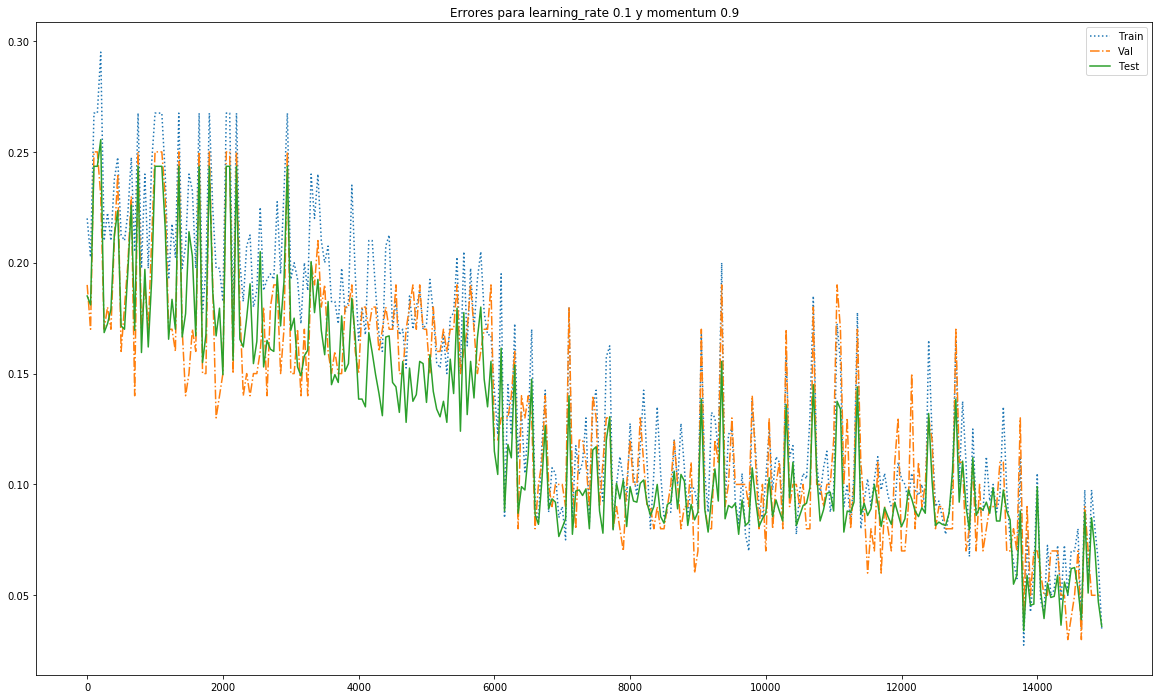

In [172]:
best_error = 1
for lr in learning_rates:
  for m in momentums:
    red = best_redes[(lr, m)]
    if red["error_test"] < best_error:
      learning_rate, momentum = lr, m
      best_red = red
      best_error = red["error_test"]

plotEntrenamiento(f'Errores para learning_rate {learning_rate} y momentum {momentum}', best_red["errors_train"], best_red["errors_val"], best_red["errors_test"], sub_epoca, cant_epocas)

## Comentarios

A partir de la tabla resultante, se puede ver cómo la mejor red se consigue usando un learning rate de 0.1 y un momentum de 0.9.

Considero que estos pueden haber sido la mejor combinación de parámetros ya que ese learning rate permite a la red modificar de manera significativa sus pesos, y este momentum tan grande evita que se quede estancada en un mínimo, permitiendo seguir buscando uno mejor (de existir este).

Lo que escribí en el párrafo anterior se puede verificar fácilmente con el gráfico resultante. Al observar que el valor de learning rate es el mayor posible, se genera que los errores en el gráfico sean tan erráticos. Y siendo el valor de momentum tan grande, esto provoca que en las épocas 6000 y 14000 los errores bajen abruptamente, ya que está encontrando un nuevo mínimo.

# Ejercicio 3

In [99]:
data = pd.read_csv('./ikeda.data', header=None, delim_whitespace=True, names=['1', '2', '3', '4', '5', 'Target'])
test = pd.read_csv('./ikeda.test', header=None, delim_whitespace=True, names=['1', '2', '3', '4', '5', 'Target'])

xData = data[['1', '2', '3', '4', '5']].values
yData = data['Target'].values

testDF = test.sample(n=2000)

xTest = testDF[['1', '2', '3', '4', '5']].values
yTest = testDF['Target'].values

In [100]:
momentum = 0.9
learning_rate = 0.01
iters = 10
neuronas = 30
sub_epocas = 50
cant_epocas = 400

## 95-5

In [118]:
xTrain, xVal, yTrain, yVal = train_test_split(xData, yData, test_size=0.05)

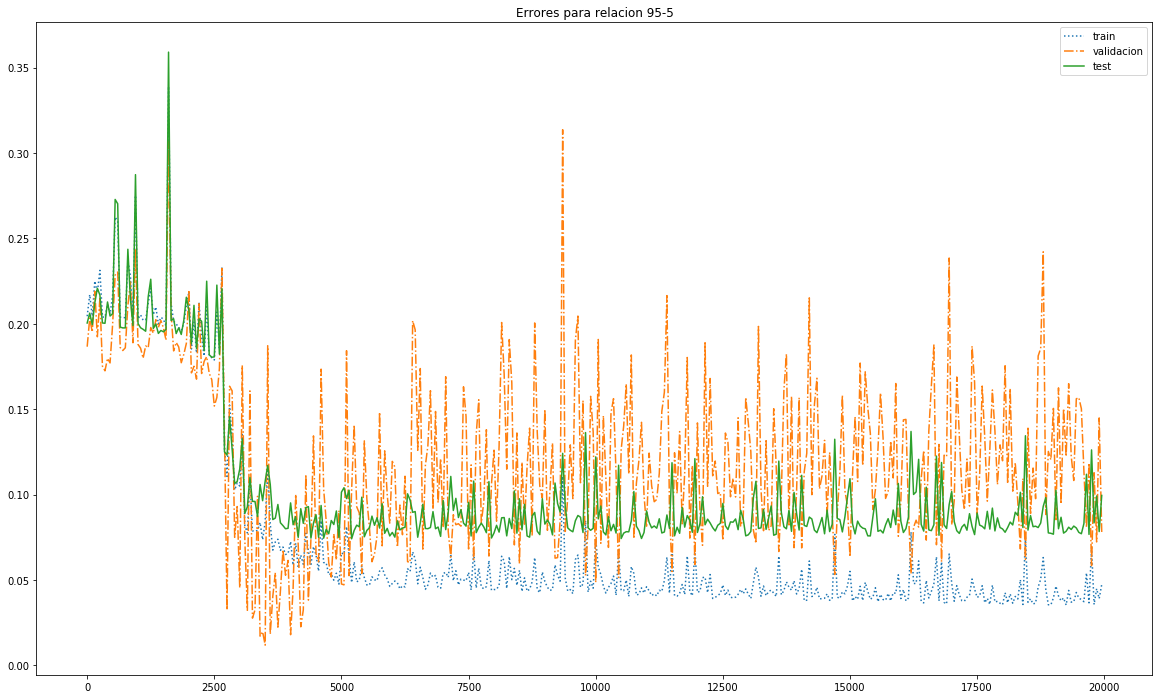

In [119]:
regre = MLPRegressor(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                       momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)

best_red, error_train, error_val, error_test = entrenar_red(regre, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)

plotEntrenamiento(f'Errores para relacion 95-5', error_train, error_val, error_test, sub_epocas, cant_epocas)

## 75-25

In [107]:
xTrain, xVal, yTrain, yVal = train_test_split(xData, yData, test_size=0.25)

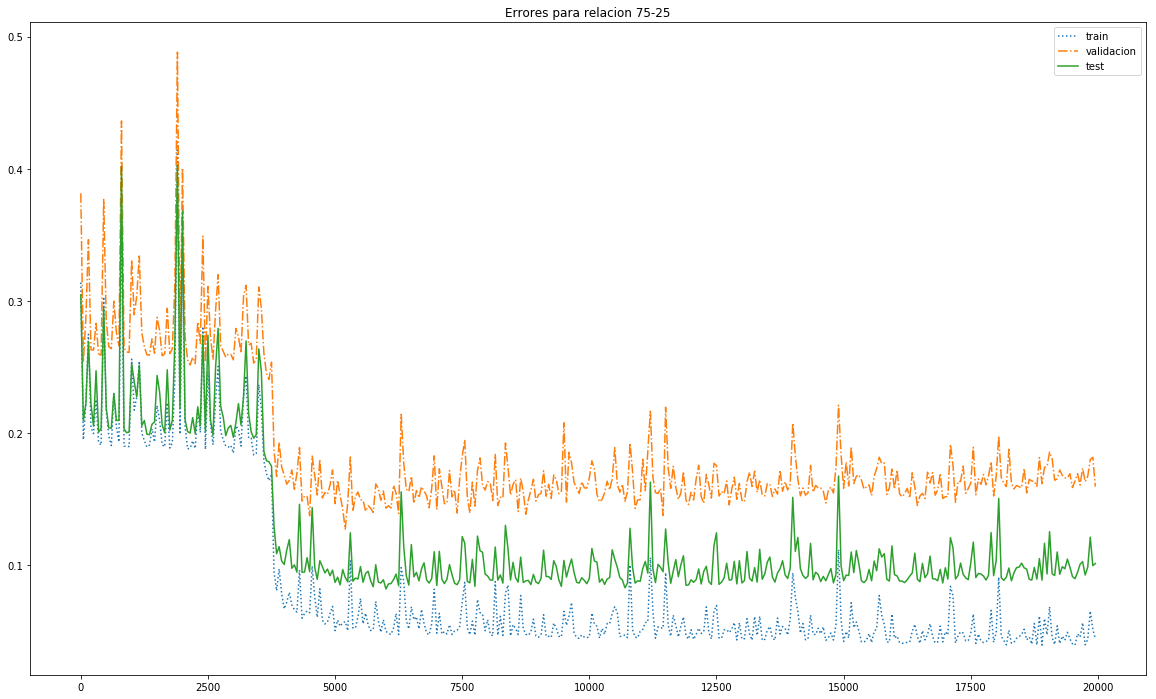

In [108]:
regre = MLPRegressor(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                       momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)

best_red, error_train, error_val, error_test = entrenar_red(regre, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)

plotEntrenamiento(f'Errores para relacion 75-25', error_train, error_val, error_test, sub_epocas, cant_epocas)

## 50-50

In [105]:
xTrain, xVal, yTrain, yVal = train_test_split(xData, yData, test_size=0.5)

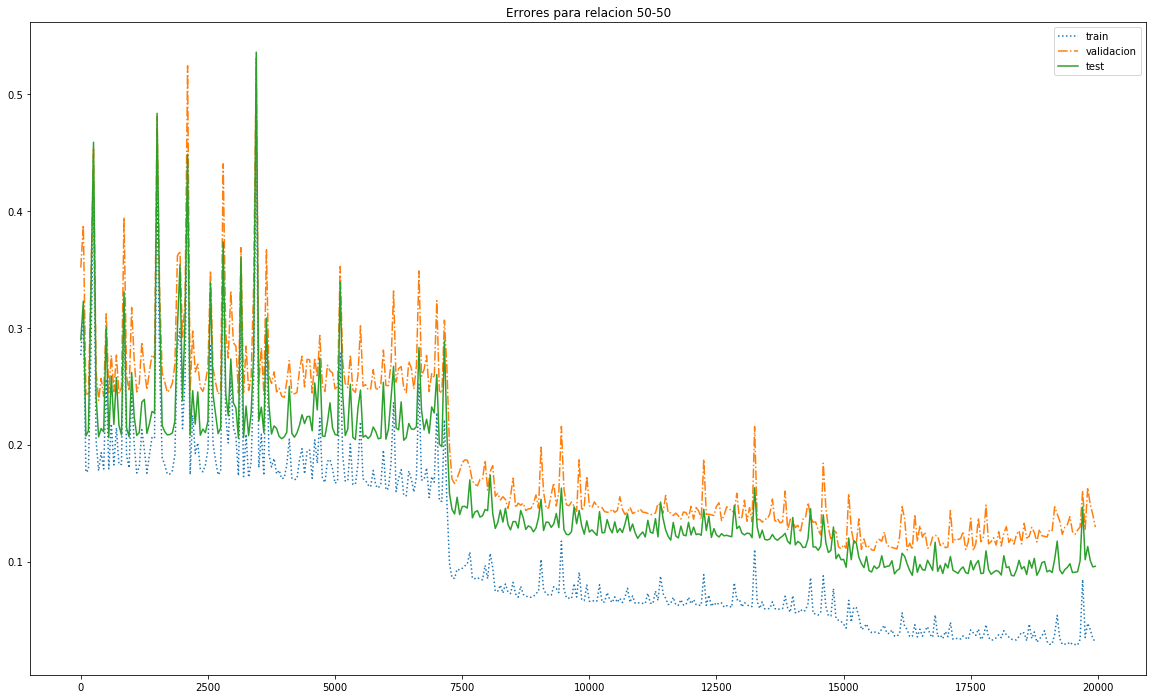

In [106]:
regre = MLPRegressor(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                       momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)

best_red, error_train, error_val, error_test = entrenar_red(regre, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)

plotEntrenamiento(f'Errores para relacion 50-50', error_train, error_val, error_test, sub_epocas, cant_epocas)

## Comentarios

A medida que se va reduciendo el porcentaje de datos de entrenamiento, se puede ver cómo las predicciones del conjunto de validación se vuelven menos erráticas. Esto en sí es una clara ventaja, ya que al tener más datos de validación, se puede estar más seguro al momento de elegir una red, pues esta se verificó con una muestra más significativa de datos, lo que permite predecir con mayor certeza los casos nuevos. De esta manera, aunque en el caso de 95-5 se consiguió un mejor entrenamiento, sin tener un conjunto de validación lo suficientemente grande, no se podría elegir una red confiando en que sea la mejor entrenada.

Ahora, en el otro extremo, teniendo una proporción 50-50 (entrenamiento-validación), tenemos un conjunto de validación en el que podemos confiar para encontrar una de las mejores redes que entrenamos. A pesar de esto, sin tener suficientes casos de entrenamiento, el entrenamiento que conseguimos no es tan bueno, ya que probablemente no pudo entrenar la red para los diferentes tipos de casos que puede haber.

Yo elegiría una relación 75-25, ya que, aunque no se consiga un entrenamiento tan bueno como en el caso de 95-5 y el conjunto de validación no sea tan confiable como en el caso de 50-50, esta relación me permitiría tener un conjunto de validación moderadamente confiable y suficientes datos de entrenamiento como para poder entrenar adecuadamente una red y poder elegir con mayor confianza la que considere mejor.

# Ejercicio 4

## Calculos


In [177]:
learning_rate = 0.05
momentum = 0.3
sub_epocas = 20
cant_epocas = 4000
neuronas = 6
weight_decay = [10**(-4), 10**(-6)]

In [178]:
weight_decay = [10**(-n) for n in range(7)]

In [179]:
data = pd.read_csv('./ssp.data', header=None, names=([str(n) for n in range(12)] + ['Target']))
test = pd.read_csv('./ssp.test', header=None, names=([str(n) for n in range(12)] + ['Target']))

xTrain = data[[str(n) for n in range(12)]].values
yTrain = data['Target'].values

xTest = test[[str(n) for n in range(12)]].values
yTest = test['Target'].values

In [180]:
values = {}

for wd in weight_decay:
  regre = MLPRegressor(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=wd, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                        momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)
  
  red, error_train, error_test, weights = entrenar_red2(regre, cant_epocas, xTrain, yTrain, xTest, yTest)

  values[wd] = {'error_train': error_train, 'error_test': error_test, 'weights': weights}

## Errores

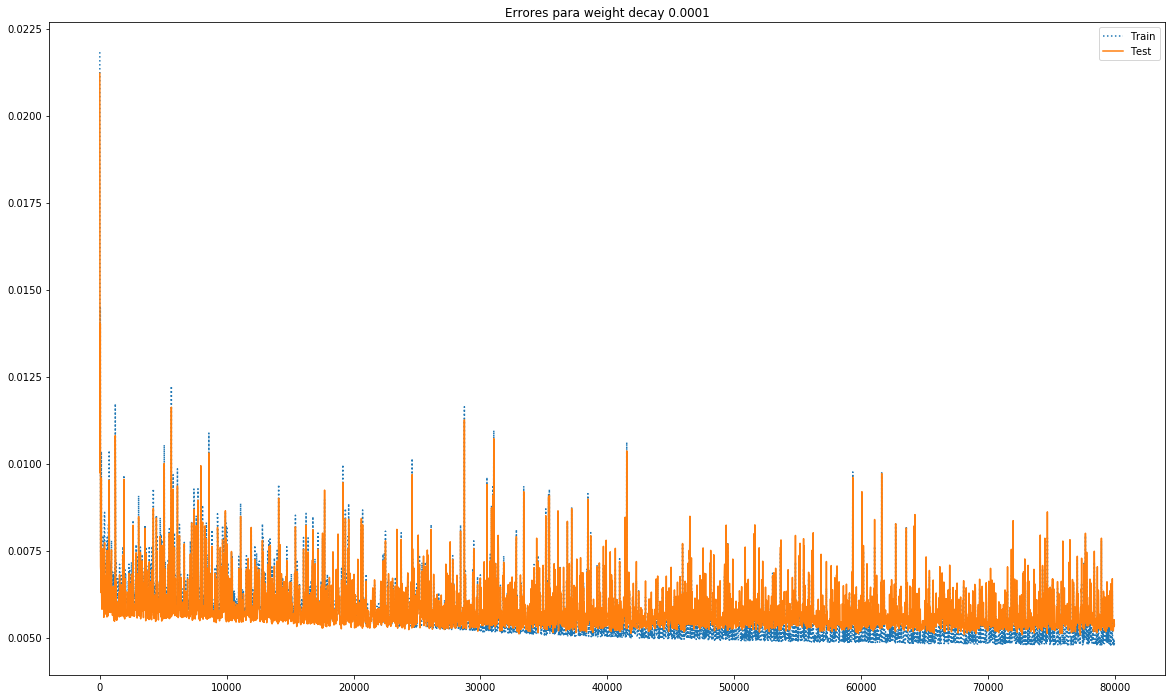

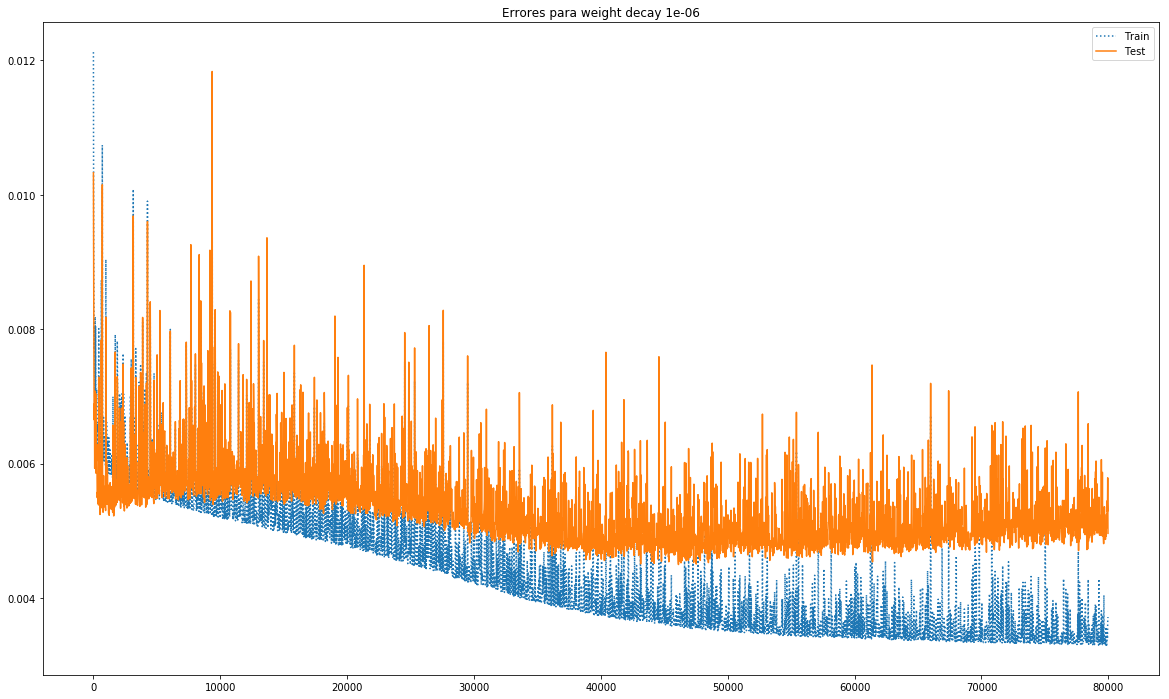

In [87]:
for k, v in values.items():
  plotEntrenamiento2(f'Errores para weight decay {k}', v["error_train"], v["error_test"], sub_epocas, cant_epocas)

## Pesos

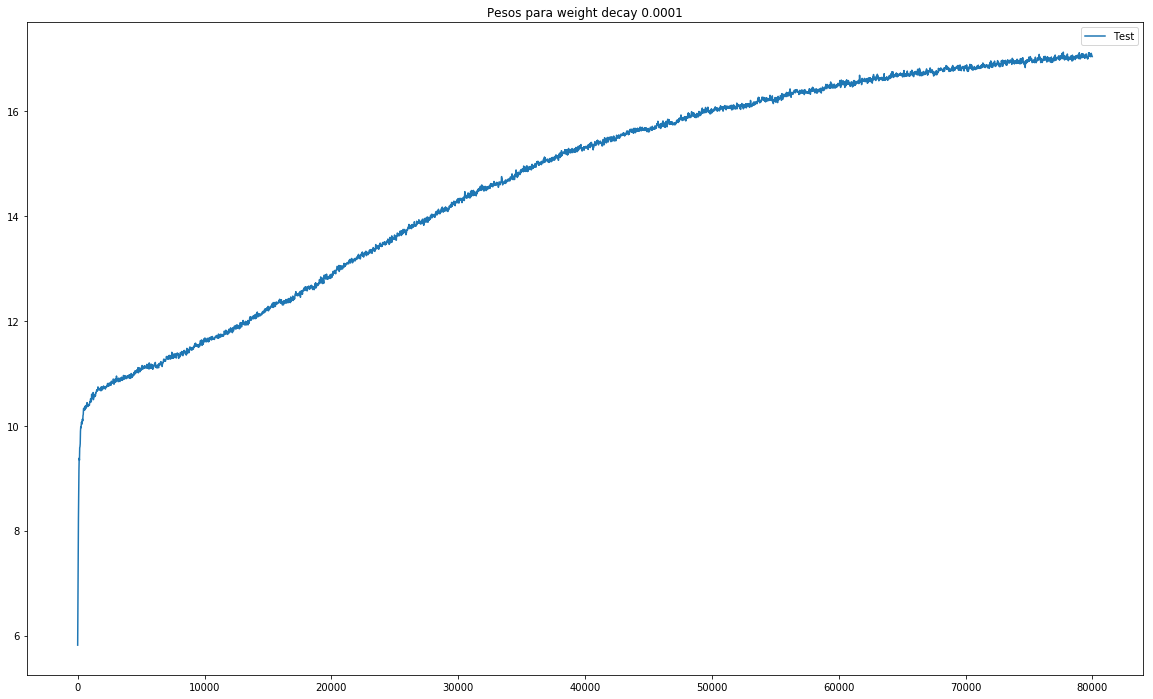

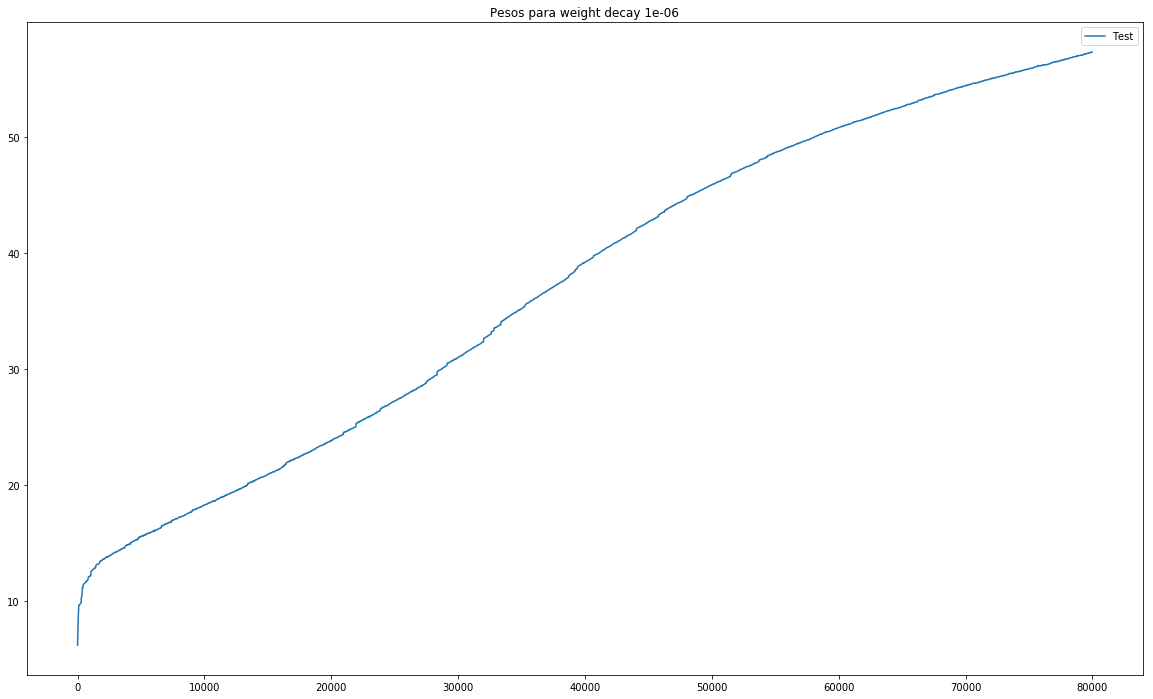

In [88]:
for k, v in values.items():
  plotEntrenamiento3(f'Pesos para weight decay {k}', v["weights"], sub_epocas, cant_epocas)

## Comentarios

Los valores de weight decay que elegí son 10^(-4) para el mejor valor y 10^(-6) para el caso con sobreajuste. Desde valores de 1 hasta 10^(-4), se podía ver una clara mejoría en los errores, pero al llegar a 10^(-5) y más aún en 10^(-6), se puede ver cómo los errores de entrenamiento y testeo se van separando, y el de testeo sube lentamente. Esto da claramente señales de sobreajuste, lo cual se origina a partir de que, como no se está limitando el crecimiento de los pesos de la red, esta busca soluciones aún más complejas para el caso de entrenamiento y se enfoca en las características de estas muestras más que en generalizaciones.

# Ejercicio 5

## Calculos

In [ ]:
dimensiones = [2, 4, 8, 16, 32]
learning_rate = 0.1
momentum = 0.9
weight_decay = 10**(-4)
sub_epocas = 50
cant_epocas = 300
neuronas = 6

errorPara = {}
errorDiag = {}
errorDiagANN = {}
errorParaANN = {}

In [153]:
for i in dimensiones:
  test = diagonales(10000, i, 0.78)

  xTest = test[['d' + str(n + 1) for n in range(i)]].values
  yTest = test['Target'].values

  errorTree, errorANN = [], []

  for _ in range(20):
    train = diagonales(250, i, 0.78)

    xTrain = train[['d' + str(n + 1) for n in range(i)]].values
    yTrain = train['Target'].values

    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    clf.fit(xTrain, yTrain)

    errorTree.append((1 - clf.score(xTrain, yTrain), 1 - clf.score(xTest, yTest)))

    clasif = MLPClassifier(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=weight_decay, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                          momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)
    
    _, error_train, error_test, _ = entrenar_red2(clasif, cant_epocas, xTrain, yTrain, xTest, yTest)

    errorANN.append((error_train[-1], error_test[-1]))

  errorDiag[i] = (np.average([x for x, y in errorTree]), np.average([y for x, y in errorTree]))
  errorDiagANN[i] = (np.average([x for x, y in errorANN]), np.average([y for x, y in errorANN]))

In [154]:
for i in dimensiones:
  test = paralelas(10000, i, 0.78)

  xTest = test[['d' + str(n + 1) for n in range(i)]].values
  yTest = test['Target'].values

  errorTree, errorANN = [], []

  for _ in range(20):
    train = paralelas(250, i, 0.78)

    xTrain = train[['d' + str(n + 1) for n in range(i)]].values
    yTrain = train['Target'].values

    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    clf.fit(xTrain, yTrain)

    errorTree.append((1 - clf.score(xTrain, yTrain), 1 - clf.score(xTest, yTest)))

    clasif = MLPClassifier(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=weight_decay, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                          momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)
    
    _, error_train, error_test, _ = entrenar_red2(clasif, cant_epocas, xTrain, yTrain, xTest, yTest)

    errorANN.append((error_train[-1], error_test[-1]))

  errorPara[i] = (np.average([x for x, y in errorTree]), np.average([y for x, y in errorTree]))
  errorParaANN[i] = (np.average([x for x, y in errorANN]), np.average([y for x, y in errorANN]))

## Graficos

In [173]:
errDiagArbol = ([v[0] for k, v in errorDiag.items()], [v[1] for k, v in errorDiag.items()])
errParaArbol = ([v[0] for k, v in errorPara.items()], [v[1] for k, v in errorPara.items()])
errDiagANN = ([v[0] for k, v in errorDiagANN.items()], [v[1] for k, v in errorDiagANN.items()])
errParaANN = ([v[0] for k, v in errorParaANN.items()], [v[1] for k, v in errorParaANN.items()])

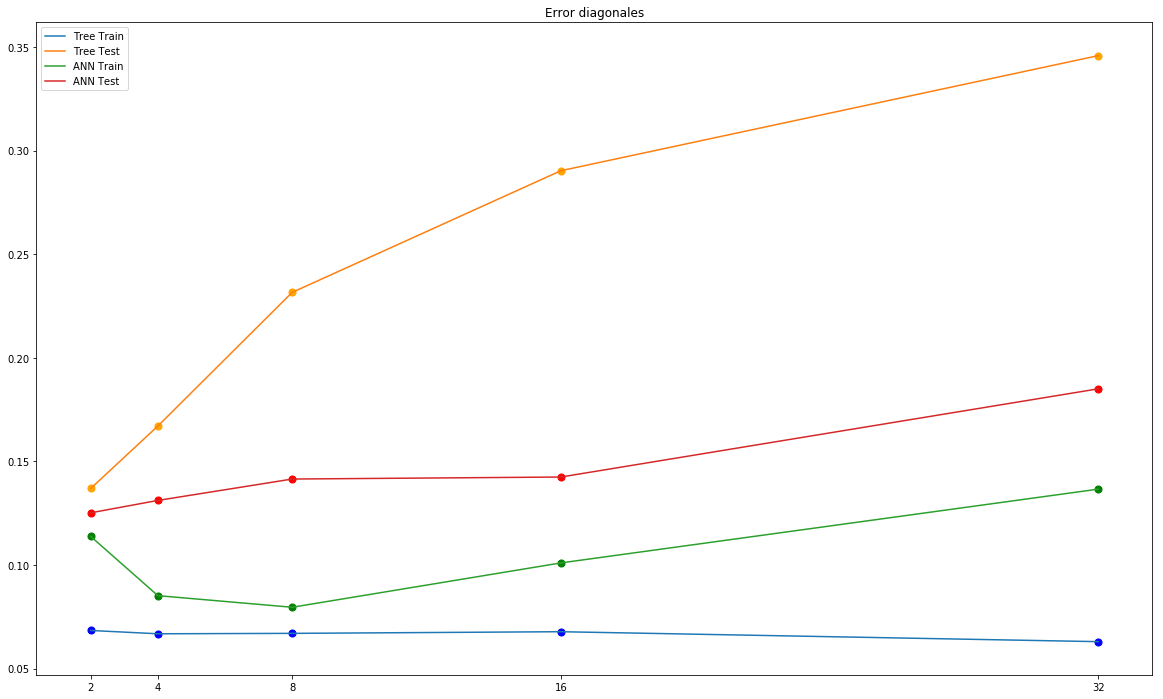

In [174]:
plotEntrenamiento5("Error diagonales", errDiagArbol, errDiagANN, dimensiones)

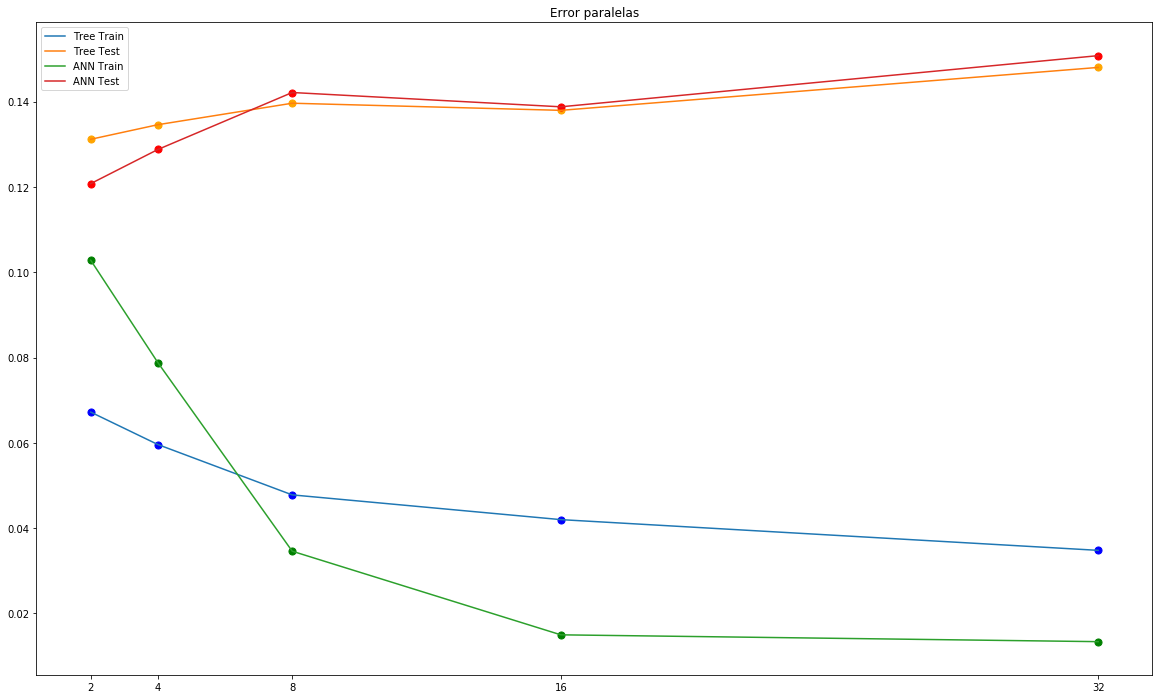

In [175]:
plotEntrenamiento5("Error paralelas", errParaArbol, errParaANN, dimensiones)

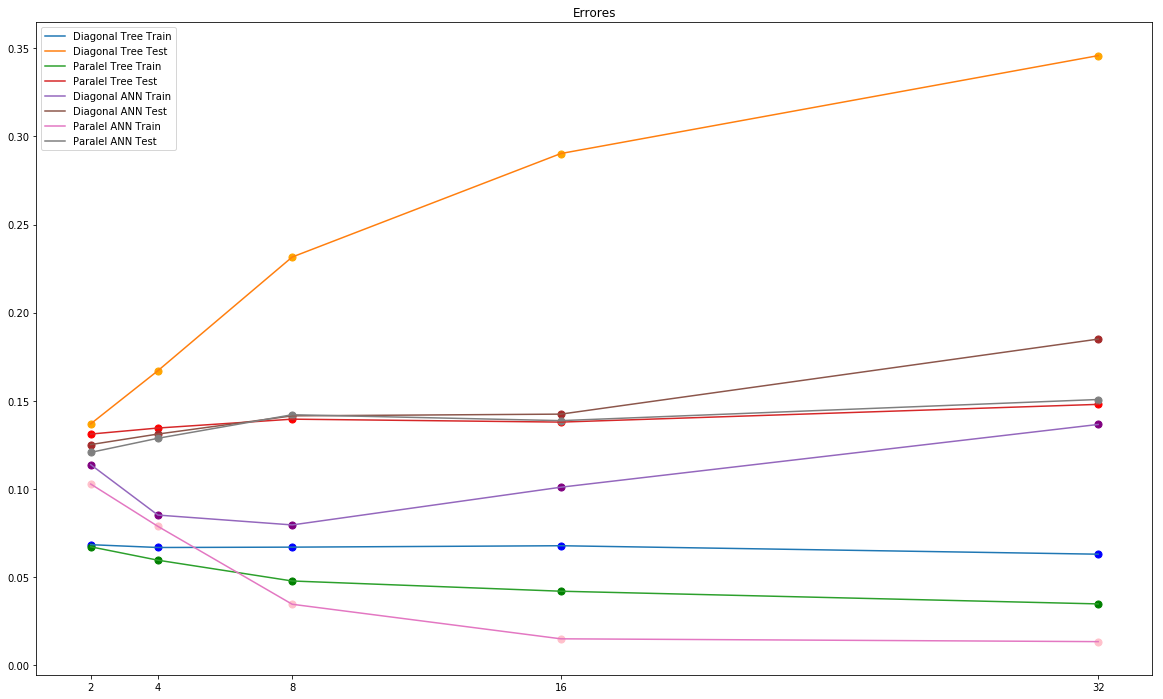

In [176]:
plotEntrenamiento4("Errores", errDiagArbol, errParaArbol, errDiagANN, errParaANN, dimensiones)

## Comentarios

Con el objetivo de ser lo más justo posible al hacer el entrenamiento con árboles y redes, decidí entrenar y testear ambas redes con exactamente los mismos datos, y conseguir el error final a partir de un promedio de 20 entrenamientos, al igual que en los árboles. Además, para no entrenar a la red con menos datos al tener un conjunto de validación, decidí utilizar weight decay.

Manteniendo los parámetros de los ejercicios anteriores que considero que mejor funcionaron, elegí:

learning rate: 0.1

momentum: 0.9

neuronas: 6

weight decay: 10^(-4)


Para el caso de las épocas, simplemente elegí valores de épocas con el objetivo de que no le falte entrenamiento a la red y pueda encontrar un buen mínimo.

En el caso de las diagonales, se puede ver una clara mejoría usando redes sobre árboles; esto se debe a la dificultad de los árboles de poder definir un sistema lo suficientemente complejo que separe apropiadamente ambos grupos.

En cuanto a las paralelas, la única diferencia vista es que, usando redes, el conjunto de entrenamiento consiguió un menor error que el de árboles. Pero los casos de testeo dieron básicamente los mismos resultados. Considero que esto se debe a que, ya que el problema no era difícil de resolver, ambos consiguieron valores cercanos al mínimo error que planteamos en el ejercicio 3.1 del trabajo anterior.

Cabe aclarar que, en el caso de las diagonales, la red también parece haber conseguido acercarse bastante al error mínimo planteado en el trabajo anterior.

# Ejercicio 6

## Iris

In [65]:
from sklearn.datasets import load_iris

iris = load_iris()

xTest, xData, yTest, yData = train_test_split(iris["data"], iris["target"], test_size=0.6666)

xTrain, xVal, yTrain, yVal = train_test_split(xData, yData, test_size=0.2)

In [66]:
learning_rate = 0.001
momentum = 0.1
sub_epocas = 1
cant_epocas = 1000
neuronas = 3

In [67]:
errorTest, errorTrain, errorVal = [], [], []

clasif = MLPClassifier(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                       momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)

best_red, errors_train, errors_val, errors_test = entrenar_red(clasif, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)

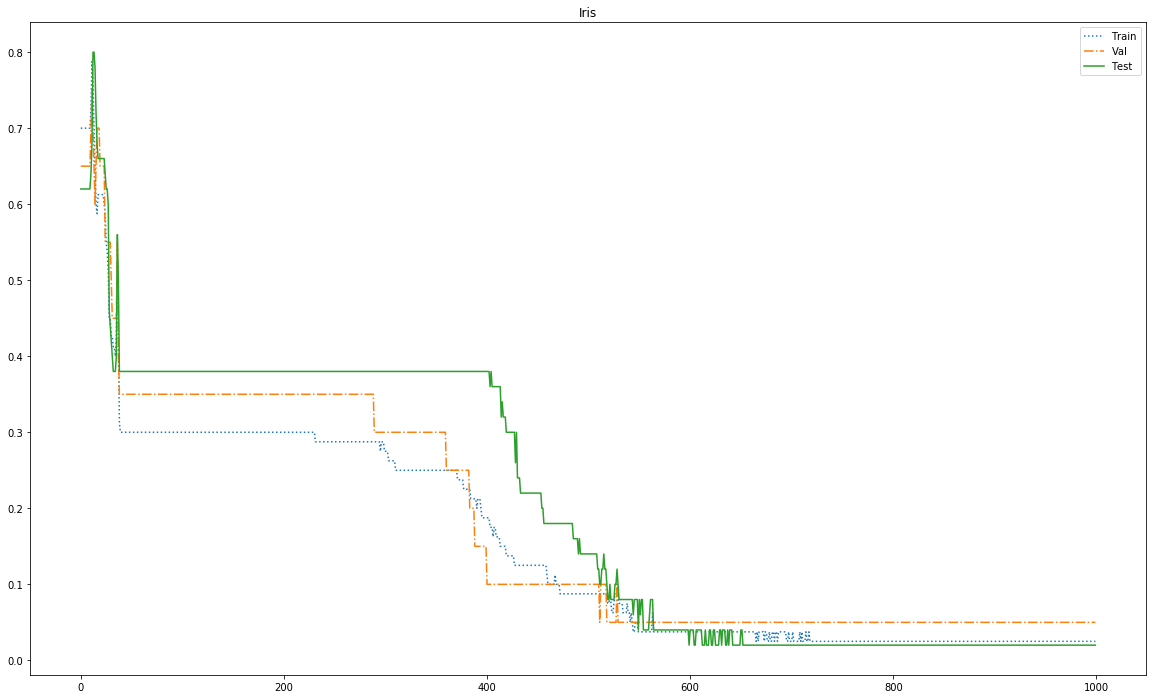

In [68]:
plotEntrenamiento("Iris", errors_train, errors_val, errors_test, sub_epocas, cant_epocas)

## Comentarios

Para este ejercicio, tuve que jugar un poco con los parámetros, ya que un learning rate mayor ocasionaba que los errores fueran más erráticos y no lograban converger a un valor. Además, un learning rate más bajo me permitía tener una mejor vista de la gráfica, ya que los otros, al ser mayores, convergían muy rápidamente y no me permitían tener una buena percepción de cómo bajaban los errores. Un momentum mayor causaba un efecto similar, ya que la red se movía constantemente a otros mínimos locales, que casi siempre eran peores que el ya encontrado.

Además, como el conjunto de entrenamiento es tan pequeño, establecí que las sub-épocas fueran 1 y utilicé un máximo de 1000 épocas para poder ver el cambio época a época.

Vale notar que, siendo tan pequeños los conjuntos de entrenamiento, validación y testeo, tuve que realizar varios entrenamientos hasta encontrar uno satisfactorio. Muchas veces los conjuntos no tenían la suficiente variedad de casos, y no lograba entrenar adecuadamente a la red.

## Faces

In [132]:
data = pd.read_csv('./faces.data', header=None, names=([str(n) for n in range(960)] + ['Target']))
test = pd.read_csv('./faces.test', header=None, names=([str(n) for n in range(960)] + ['Target']))

datos = np.concatenate((data[[str(n) for n in range(960)]].values, test[[str(n) for n in range(960)]].values), axis=None)

maximum = np.max(datos)

facesData = [x/maximum for x in data[[str(n) for n in range(960)]].values]
xTrain, xVal, yTrain, yVal = train_test_split(facesData, data["Target"], test_size=0.2)

xTest = [x/maximum for x in test[[str(n) for n in range(960)]].values]
yTest = test["Target"]

In [133]:
learning_rate = 0.001
momentum = 0.7
sub_epocas = 1
cant_epocas = 500
neuronas = 30

In [134]:
errorTest, errorTrain, errorVal = [], [], []

clasif = MLPClassifier(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                       momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)

best_red, errors_train, errors_val, errors_test = entrenar_red(clasif, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)

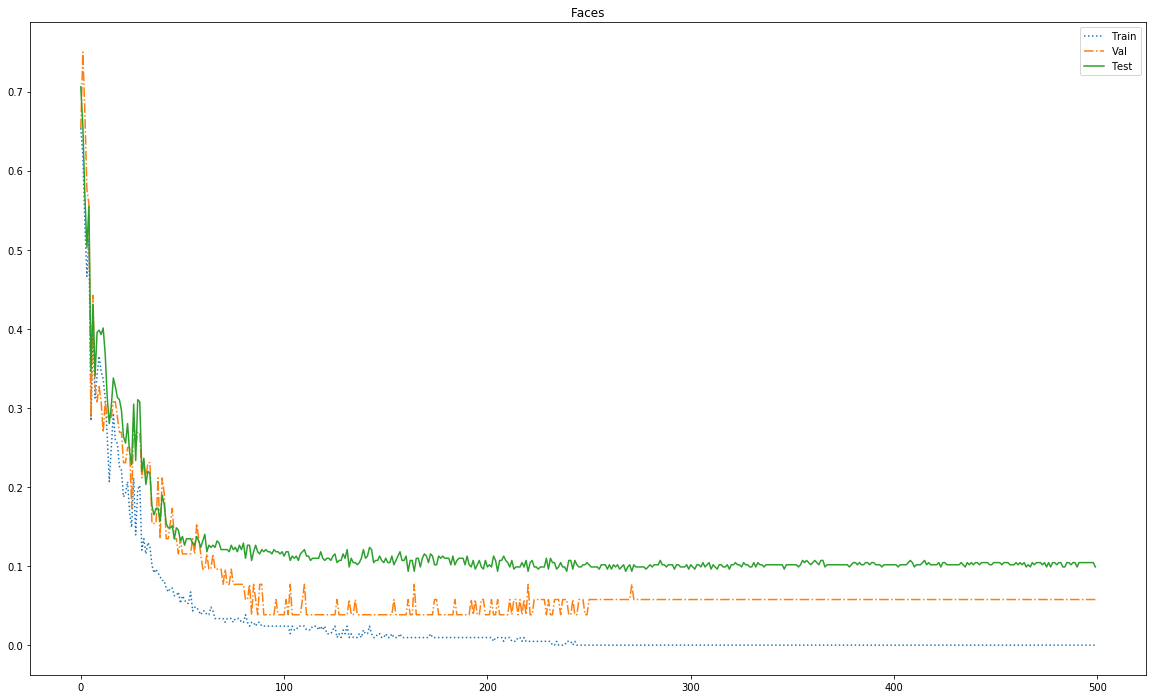

In [135]:
plotEntrenamiento("Faces", errors_train, errors_val, errors_test, sub_epocas, cant_epocas)

## Comentarios

Para este apartado, también tuve que modificar bastante los parámetros hasta encontrar una combinación que considerara satisfactoria. La idea del learning rate sigue siendo la misma: probé con valores mayores, pero volvían la gráfica muy errática y no lograba converger.

Además, noté que con valores más bajos de momentum, al encontrar un mínimo local menor que el visto en la gráfica, la red se estancaba ahí. Y con valores mayores, los errores saltaban de mínimo a mínimo constantemente.

Por último, evaluando las muestras del conjunto de entrenamiento, se puede ver que estas son bastante complejas (960 valores por muestra). De esta manera, hice el entrenamiento con 30 neuronas para poder conseguir redes lo suficientemente complejas como para encontrar una buena solución.

El accuracy conseguido con mi red (cerca del 90%) es casi el mismo que en el libro de Mitchell, pero los parámetros son bastante diferentes que allí (lr = 0.3, m = 0.3, N2 = 3/30). Fuera del número de neuronas, que en el libro también se probó con 30 y se vio que tenía mayor accuracy que con valores menores, mi learning rate fue mucho menor y mi momentum bastante mayor. Mi decisión del learning rate fue en parte para poder conseguir valores en los errores que me permitieran apreciar cómo bajan mientras pasan las épocas (igual que en el apartado anterior). Ahora, mi valor de momentum probablemente tuvo que ser tan alto ya que, al ser tan pequeño el learning rate, la red no conseguía hacer suficientes cambios y tardaba mucho en converger (si es que lograba hacerlo).

# Ejercicio 7

## Calculos

In [124]:
data = pd.read_csv('./ssp.data', header=None, names=([str(n) for n in range(12)] + ['Target']))
test = pd.read_csv('./ssp.test', header=None, names=([str(n) for n in range(12)] + ['Target']))

xData = data[[str(n) for n in range(12)]].values
yData = data['Target'].values

xTrain, xVal, yTrain, yVal = train_test_split(xData, yData, test_size=0.2)

xTest = test[[str(n) for n in range(12)]].values
yTest = test['Target'].values

In [125]:
learning_rate = 0.05
momentum = 0.3
sub_epocas = 200
cant_epocas = 2000
neuronas = 6
batch_size = [1, 12, 36]

In [126]:
values = {}

for bs in batch_size:
  regre = MLPRegressor(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=0, batch_size=bs, learning_rate='constant', learning_rate_init=learning_rate, 
                        momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)
  
  red, error_train, error_val, error_test = entrenar_red(regre, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)

  values[bs] = {'error_train': error_train, 'error_val': error_val, 'error_test': error_test}

## Graficos

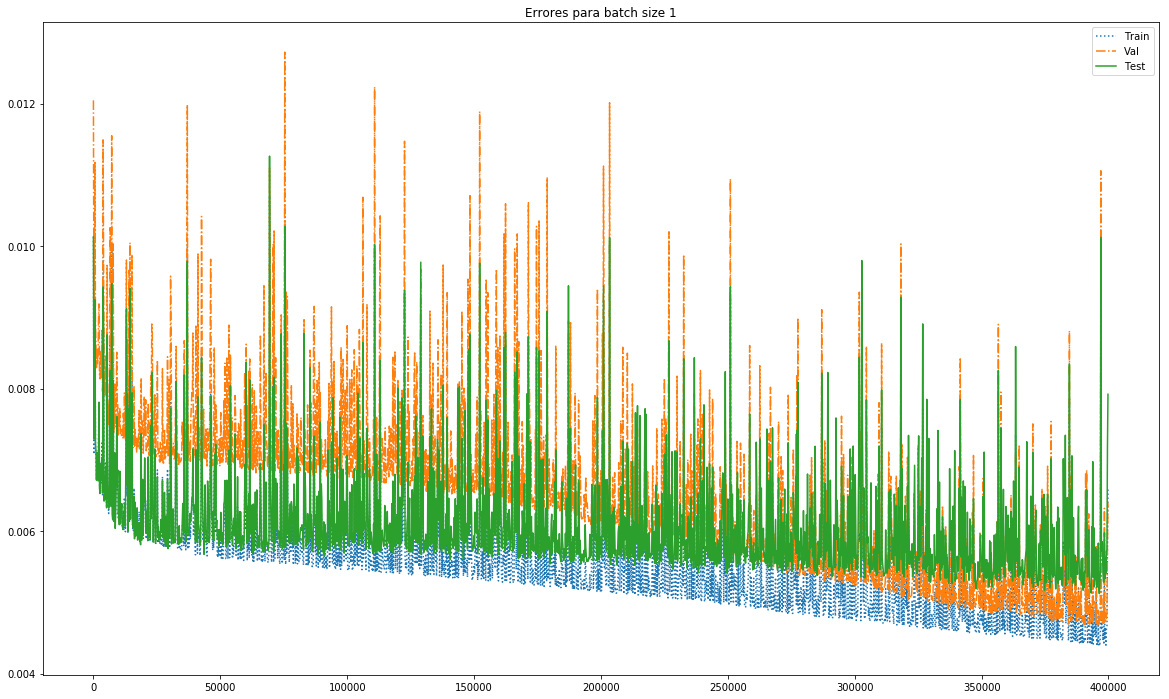

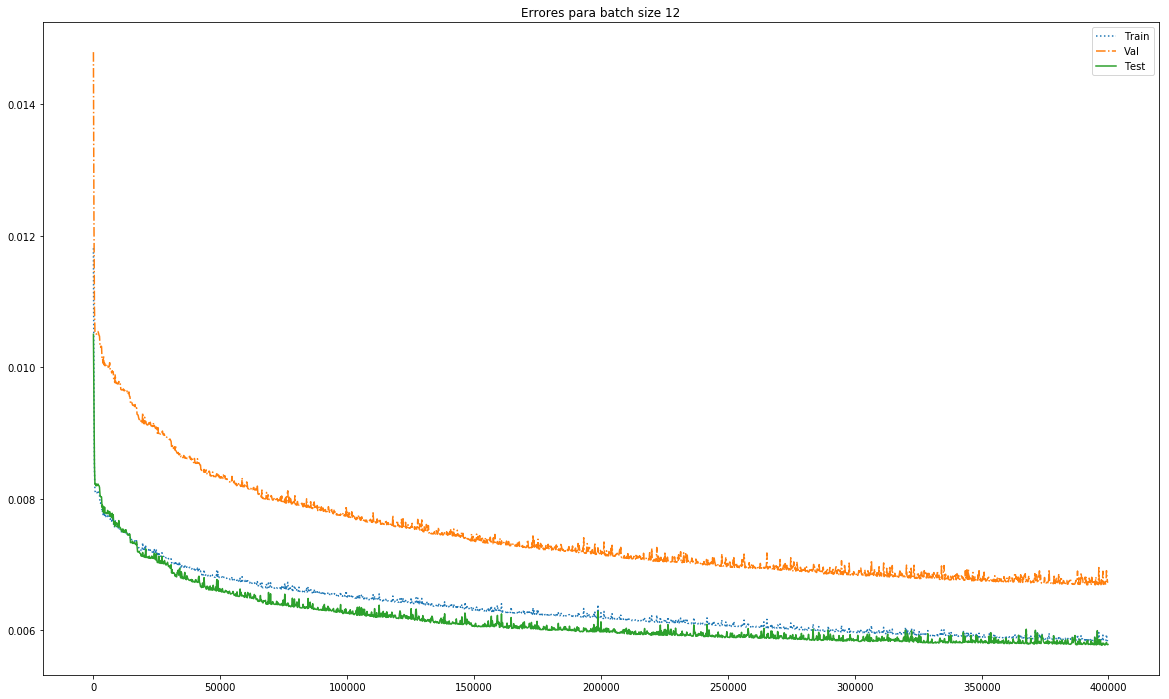

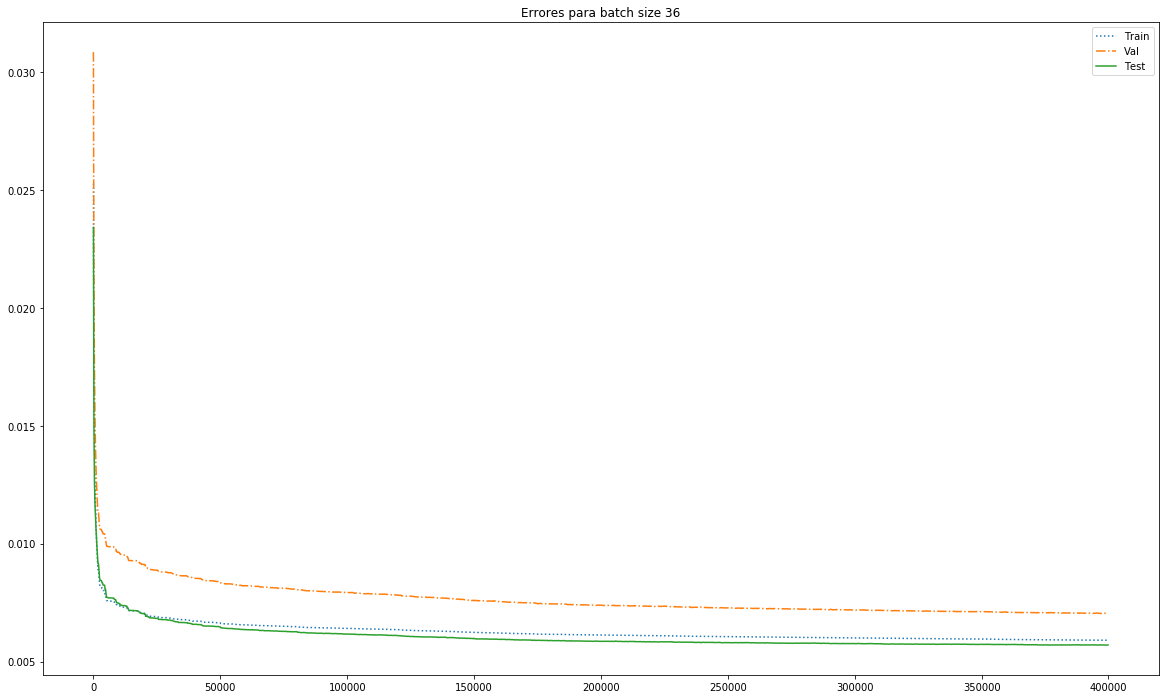

In [127]:
for k, v in values.items():
  plotEntrenamiento(f'Errores para batch size {k}', v["error_train"], v["error_val"], v["error_test"], sub_epocas, cant_epocas)

## Comentarios

Las principales diferencias que se pueden notar en los gráficos es que, al aumentar el tamaño del batch size, se encuentra la solución más rápido y los errores se vuelven menos erráticos.

Esto se debe a que al no modificar los pesos cada vez que se toman nuevos datos, sino que se hacen las modificaciones a partir de un promedio de los resultados de cada muestra, una muestra muy diferente al resto no modificará de gran manera a la red en una época dada ya que se promediará con los resultados de las muestras restantes. De esta manera, la red encontrará un mínimo más velozmente y, además, el tiempo de entrenamiento probablemente sea significativamente menor al no estar modificando los pesos de la red constantemente (yo corri los 3 batch size en la misma funcion, asi que es una suposición).